# การทำนายลักษณะกลุ่มโรคของพืช โดยใช้ Plant Disease Model

ตัวอย่างนี้จะเป็นการทำนายลักษณะกลุ่มโรคของพืช (Plant Disease) จากรูปภาพใบไม้ ซึ่งขั้นตอนการนำภาพถ่ายมาผ่านโปรแกรมทำนายลักษณะกลุ่มโรคของพืชได้สรุปเอาไว้ 4 ขั้นตอน ดังนี้

โดยมีรายละเอียดพร้อมตัวอย่างโค้ดในขั้นตอนต่าง ๆ คือ<br>
**ขั้นตอนที่ 1** นำเข้าชุดข้อมูลสำหรับการเทรนโมเดล<br>
**ขั้นตอนที่ 2** เตรียมชุดข้อมูลสำหรับการเทรนโมเดล<br>
**ขั้นตอนที่ 3** สร้างและเทรนโมเดล<br>
**ขั้นตอนที่ 4** ทำนายลักษณะกลุ่มโรคของพืชผ่านโมเดลที่เตรียมไว้<br>

In [ ]:
#@title **ขั้นตอนที่ 1** นำเข้าชุดข้อมูลสำหรับการเทรนโมเดล
#@markdown เป็นขั้นตอนการดาวน์โหลดชุดข้อมูลจาก https://data.mendeley.com/datasets/tywbtsjrjv/1 ซึ่งเป็นชุดข้อมูลที่ Tensorflow นำมาใช้ในการเทรนโมเดล

import os
import shutil
import urllib.request
import zipfile
import re

# ฟังก์ชั่นสำหรับแตกไฟล์ ZIP
def extract_zip(filepath):
  with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall()

# ฟังก์ชั้นสำหรับลบโฟลเดอร์ที่ไม่เกี่ยวข้อง
def remove_folder_selected(path,start_name):
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        if not filename.startswith(start_name):
            if os.path.isfile(file_path):
                os.remove(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)

# ฟังก์ชั่นสำหรับลบรูปที่เกินจำนวนที่ต้องการ
def remove_images_after(path,max_images):
    for folder_name in os.listdir(path):
        folder_dir = os.path.join(path, folder_name)
        if os.path.isdir(folder_dir):
            image_count = 1
            for filename in os.listdir(folder_dir):
                match = re.search(r"\((\d+)\)", filename)
                if match:
                    number = int(match.group(1))
                    if number > max_images:
                        file_path = os.path.join(folder_dir, filename)
                        os.remove(file_path)

# ดาวน์โหลดโฟลเดอร์ชุดข้อมูลทั้งหมด
url = 'https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/tywbtsjrjv-1.zip'
filename = 'plant_leaves_dataset.zip'
urllib.request.urlretrieve(url, filename)
extract_zip(filename)
os.remove(filename)

# แยกเฉพาะไฟล์รูปที่ต้องการเพื่อใช้เทรนโมเดล
folder_dir = 'Data for Identification of Plant Leaf Diseases Using a 9-layer Deep Convolutional Neural Network'
folder_filename = 'Plant_leaf_diseases_dataset_without_augmentation.zip'
folder_path = os.path.join(folder_dir,folder_filename)
extract_zip(folder_path)
shutil.rmtree(folder_dir)
folder_name = 'Plant_leave_diseases_dataset_without_augmentation'
remove_folder_selected(folder_name,'Apple__')
remove_images_after(folder_name,300)

print('Loading dataset.. Done.')

Loading dataset.. Done.


Number of images: 1175
Number of classes: 4



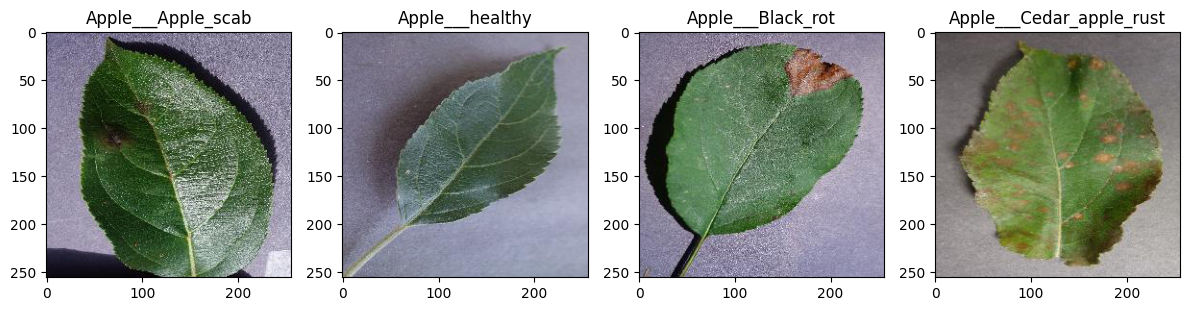

In [74]:
#@title **ขั้นตอนที่ 2** เตรียมชุดข้อมูลสำหรับการเทรนโมเดล
#@markdown เป็นขั้นตอนการเตรียมชุดข้อมูลโดยแยกรูปภาพกับชื่อกลุ่ม สำหรับนำมาใช้ในการเทรนโมเดล ประกอบด้วย<br>1. Apple__Apple_scab<br>2. Apple__healthy<br>3. Apple__Black_rot<br>4. Apple__Cedar_apple_rust<br>

import os
import cv2
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# ฟังก์ชั่นสำหรับนำเข้ารูปภาพและปรับสัดส่วนค่าสี (intensity) ให้อยู่ในช่วง 0 - 1
def load_images(filename):
    img = io.imread(filename)
    img = cv2.resize(img, (64, 64)) # resize to match inputs of model
    img = img / 255.0 # normalize image data
    img = img.astype(np.float32)
    return img

# ฟังก์ชั่นสำหรับนำเข้ารูปภาพและชื่อ labels จากโฟลเดอร์
def load_images_from_folder(folder):
    images = []
    labels = []
    for foldername in os.listdir(folder):
        for filename in os.listdir(os.path.join(folder, foldername)):
            if filename.endswith('.JPG'):
                filepath = os.path.join(folder, foldername, filename)
                img = load_images(filepath)
                images.append(img)
                labels.append(foldername)  # Use folder name as the label .split('/')[-1]
    return images, labels

# นำเข้ารูปภาพและชื่อ class ของแต่ละรูป
folder = 'Plant_leave_diseases_dataset_without_augmentation'
images, labels = load_images_from_folder(folder)

# แบ่งข้อมูลสำหรับ training และ testing
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# ปรับตัวแปรให้สอดคล้องกับความต้องการของโมเดล
X_train = np.array(X_train).reshape(len(X_train), -1)
X_test = np.array(X_test).reshape(len(X_test), -1)

# แสดงผลจำนวนรูปภาพที่ใช้และกลุ่ม class ทั้งหมด
print("Number of images:",len(labels))
print("Number of classes:",len(np.unique(labels)))
print('')

# แสดงผลรูปตัวอย่างในแต่ละกลุ่ม
folder_names = os.listdir(folder)
fig, axes = plt.subplots(1, len(folder_names), figsize=(15, 3))
for i, folder_name in enumerate(folder_names):
    file_names = os.listdir(os.path.join(folder, folder_name))
    image_path = os.path.join(folder,folder_name, file_names[0])
    image = io.imread(image_path)
    axes[i].imshow(image)
    axes[i].set_title(folder_name)
plt.tight_layout()
plt.show()

In [ ]:
#@title **ขั้นตอนที่ 3** สร้างและเทรนโมเดล
#@markdown เป็นขั้นตอนการสร้างโมเดลเพื่อจำแนกรายละเอียดของรูปและเทรนโมเดลจากชุดข้อมูลที่เตรียมไว้ โดยมีการแสดงผล Accuracy จากรูปชุดทดสอบ

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

# โครงสร้างของโมเดลที่ใช้ทำนาย
model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=512)),
    ('svm', SVC())
])

# เทรนโมเดล
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
execution_time = end_time - start_time
print('Done training.')
print(f"Execution training time: {execution_time} seconds")
print('')

# วิเคราะห์ค่าความแม่นยำ (accuracy)
accuracy = model.score(X_test, y_test)
print('Accuracy:', accuracy)

Done training.
Execution training time: 5.166106462478638 seconds

Accuracy: 0.9106382978723404


Labels class: Apple___healthy
Predicted disease: Apple___healthy


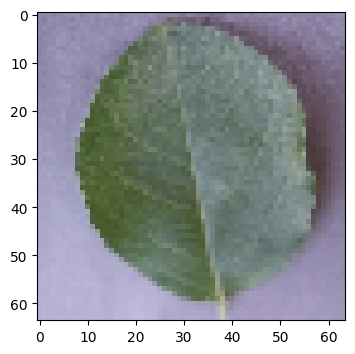

In [69]:
#@title **ขั้นตอนที่ 4** ทำนายลักษณะกลุ่มโรคของพืชผ่านโมเดลที่เตรียมไว้
#@markdown ในขั้นตอนนี้จะเป็นการนำเข้ารูปภาพที่ต้องการทำนายมาทดสอบผ่านโมเดลที่เตรียมไว้

from matplotlib import pyplot as plt

# นำเข้ารูปภาพที่ต้องการทดสอบ
filename = 'Plant_leave_diseases_dataset_without_augmentation/Apple___healthy/image (1).JPG'
img = load_images(filename)
img_input = np.array(img).reshape(1, -1)

# ทำนายกลุ่มของรูปภาพที่ต้องการทดสอบ
prediction = model.predict(img_input)
print('Labels class:',filename.split('/')[-2])
print('Predicted disease:', prediction[0])

# แสดงตัวอย่างภาพ
fig = plt.figure(figsize=(4, 4)) # define size of figure
plt.imshow(img) # display image in the figure
plt.show()

\* ไฟล์เนื้อหาทั้งหมดรวมถึงโมเดลและชุดข้อมูลสำหรับการทำนายลักษณะกลุ่มโรคของพืชนี้ สามารถเข้าไปศึกษาเพิ่มเติมและดาวน์โหลดได้ที่[ https://github.com/hengkp/microbit_ml_examples](https://github.com/hengkp/microbit_ml_examples/tree/main/microgreens%20growth%20prediction)